# Classification of Higgs Boson Particle using Random Forest Algorithm with RAPIDS AI

The ATLAS experiments at CERN uses Large Hadron Collider to produce Higgs boson particles to study about their nature. But these particles are very rare to occur. So it becomes essential to develop powerful machine learning algorithms to detect these particles. In this project I will be using machine learning algorithms from RAPIDS framework to classify between Higgs boson and a background process. The dataset is huge and handling large datasets with millions of rows and columns is difficult for Pandas. RAPIDS provides cuDF library for data preprocessing and analysis. I will be using cuDF to load the data, perform exploratory data analysis, and preprocess the data. I will use cuML library to train multiple models using GPU and compare the model results. The evaluation of the models will be done using confusion matrix and classification report. And, also the same algorithms will be trained on CPU using Scikit-Learn to compare the results between CPU and GPU. 

### Load the imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cuml
import cudf
import cupy
from cuml.metrics.accuracy import accuracy_score
from cuml.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

### Load the data

In [2]:
%%time
# Load the data using cuDF read_csv function amd save it as dataframe
df = cudf.read_csv('./Partical.csv')

CPU times: user 2.99 s, sys: 1.35 s, total: 4.35 s
Wall time: 4.44 s


## Exploratory Data Analysis

In [3]:
# Show the dataframe with rows and columns
df

,1.000000000000000000e+00,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,...,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00,1.353760004043579102e+00,9.795631170272827148e-01,9.780761599540710449e-01,9.200048446655273438e-01,7.216574549674987793e-01,9.887509346008300781e-01,8.766783475875854492e-01
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10999994,1.0,1.159912,1.013847,0.108615,1.495524,-0.537545,2.342396,-0.839740,1.320683,0.000000,...,-0.097068,1.190680,3.101961,0.822136,0.766772,1.002191,1.061233,0.837004,0.860472,0.772484
10999995,1.0,0.618388,-1.012982,1.110139,0.941023,-0.379199,1.004656,0.348535,-1.678593,2.173076,...,-0.216995,1.049177,3.101961,0.826829,0.989809,1.029104,1.199679,0.891481,0.938490,0.865269
10999996,1.0,0.700559,0.774251,1.520182,0.847112,0.211230,1.095531,0.052457,0.024553,2.173076,...,1.585235,1.713962,0.000000,0.337374,0.845208,0.987610,0.883422,1.888438,1.153766,0.931279
10999997,0.0,1.178030,0.117796,-1.276980,1.864457,-0.584370,0.998519,-1.264549,1.276333,0.000000,...,1.399515,-1.313189,0.000000,0.838842,0.882890,1.201380,0.939216,0.339705,0.759070,0.719119


The dataframe has 10999999 rows and 29 columns. The column names are not available.

After inspecting the dataset and its source UCI Machine Learning repository, I have found the below details about the dataset.
* It is a supervised learning classification problem.
* The first column is the class label representing 1 for Higgs boson signal and 0 for background process.
* The columns 2-29 are the features with the first 21 being low level features which are measured by the accelerator. The next 7 features are the high level features derived from the first 21 features. 
* The names of the features in order are lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb.

Reference:
UCI Machine Learning repository https://archive.ics.uci.edu/ml/datasets/HIGGS

In [4]:
# Column names in a list
names = ['class_label', 'lepton_pT', 'lepton_eta', 'lepton_phi',
'missing_energy_magnitude', 'missing_energy_phi',
'jet_1_pt', 'jet_1_eta', 'jet_1_phi', 'jet_1_b_tag',
'jet_2_pt', 'jet_2_eta', 'jet_2_phi', 'jet_2_b_tag',
'jet_3_pt', 'jet_3_eta', 'jet_3_phi', 'jet_3_b_tag',
'jet_4_pt', 'jet_4_eta', 'jet_4_phi', 'jet_4_b_tag',
'mjj', 'mjjj', 'mlv', 'mjlv', 'mbb', 'mwbb', 'm_wwbb']

In [5]:
# Add names of the columns in the dataframe
df.columns = names

Let's see the dataframe again with the column names

In [6]:
# Show the top 5 rows
df.head()

,class_label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,...,jet_4_eta,jet_4_phi,jet_4_b_tag,mjj,mjjj,mlv,mjlv,mbb,mwbb,m_wwbb
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818


In [7]:
# print shape of the dataframe
print('data',df.shape)

data (10999999, 29)


This info() method prints summary imformation about the dataframe. This dataframe has 10999999 rows, 29 columns. All the columns are of float64 datatype. The memory usage is 2.4 GB, as the dataset is huge and consuming large amount of memory.

In [8]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 10999999 entries, 0 to 10999998
Data columns (total 29 columns):
 #   Column                    Dtype
---  ------                    -----
 0   class_label               float64
 1   lepton_pT                 float64
 2   lepton_eta                float64
 3   lepton_phi                float64
 4   missing_energy_magnitude  float64
 5   missing_energy_phi        float64
 6   jet_1_pt                  float64
 7   jet_1_eta                 float64
 8   jet_1_phi                 float64
 9   jet_1_b_tag               float64
 10  jet_2_pt                  float64
 11  jet_2_eta                 float64
 12  jet_2_phi                 float64
 13  jet_2_b_tag               float64
 14  jet_3_pt                  float64
 15  jet_3_eta                 float64
 16  jet_3_phi                 float64
 17  jet_3_b_tag               float64
 18  jet_4_pt                  float64
 19  jet_4_eta                 float64
 20  jet_4_phi               

The description of each column with its total count, mean value, standard deviation, min, 25th percentile, 50th percentile, 75th percentile and max values of each column.

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
class_label,10999999.0,0.529920,0.499104,0.000000,0.000000,1.000000,1.000000,1.000000
lepton_pT,10999999.0,0.991466,0.565378,0.274697,0.590753,0.853371,1.236226,12.098914
lepton_eta,10999999.0,-0.000008,1.008827,-2.434976,-0.738322,-0.000054,0.738214,2.434868
lepton_phi,10999999.0,-0.000013,1.006346,-1.742508,-0.871931,-0.000241,0.870994,1.743236
missing_energy_magnitude,10999999.0,0.998536,0.600018,0.000237,0.576816,0.891628,1.293056,15.396821
missing_energy_phi,10999999.0,0.000026,1.006326,-1.743944,-0.871208,0.000213,0.871471,1.743257
jet_1_pt,10999999.0,0.990915,0.474975,0.137502,0.678993,0.894819,1.170740,9.940391
jet_1_eta,10999999.0,-0.000020,1.009303,-2.969725,-0.687245,-0.000025,0.687194,2.969674
jet_1_phi,10999999.0,0.000008,1.005901,-1.741237,-0.868096,0.000058,0.868313,1.741454
jet_1_b_tag,10999999.0,0.999969,1.027808,0.000000,0.000000,1.086538,2.173076,2.173076


The below code checks for the number of missing data in each column. As, it can be seen there are no missing values.

In [10]:
df.isnull().sum()

class_label                 0
lepton_pT                   0
lepton_eta                  0
lepton_phi                  0
missing_energy_magnitude    0
missing_energy_phi          0
jet_1_pt                    0
jet_1_eta                   0
jet_1_phi                   0
jet_1_b_tag                 0
jet_2_pt                    0
jet_2_eta                   0
jet_2_phi                   0
jet_2_b_tag                 0
jet_3_pt                    0
jet_3_eta                   0
jet_3_phi                   0
jet_3_b_tag                 0
jet_4_pt                    0
jet_4_eta                   0
jet_4_phi                   0
jet_4_b_tag                 0
mjj                         0
mjjj                        0
mlv                         0
mjlv                        0
mbb                         0
mwbb                        0
m_wwbb                      0
dtype: uint64

There is not much difference between the value counts of the two classes. The number of classes for Higgs boson is 5829122 and for background is 5170877.

In [11]:
df.class_label.value_counts()

1.0    5829122
0.0    5170877
Name: class_label, dtype: int32

Below figure shows the histogram plot for the two class labels

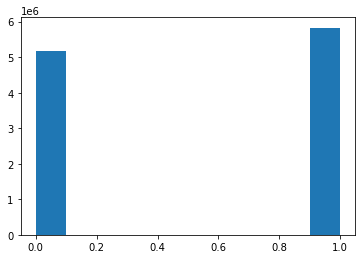

In [12]:
plt.hist(df['class_label'])
plt.show()

The below plots shows the data distribution of the the features. Some important points to notice here are.
* lepton pT, jet 1 pt, jet 2 pt,  jet  3  pt,  jet  4  pt,  and missing energy magnitude follow the same distribution pattern.
* lepton eta, jet 1 eta, jet 2 eta, jet 3 eta, jet 4 eta follow the same distribution pattern.
* lepton phi, missing energy phi, jet 1 phi, jet 2 phi, jet 3 phi, and jet 4 phi follow the same pattern. 
* jet 1 b-tag, jet 2 b-tag, jet 3 b-tag, and jet 4 b-tag follow the same pattern.
* mjj, mjjj, and mlv follow the same data distribution pattern.
* mjlv, mbb, and mwbb follow the same pattern
* m_wwbb are different from the rest.

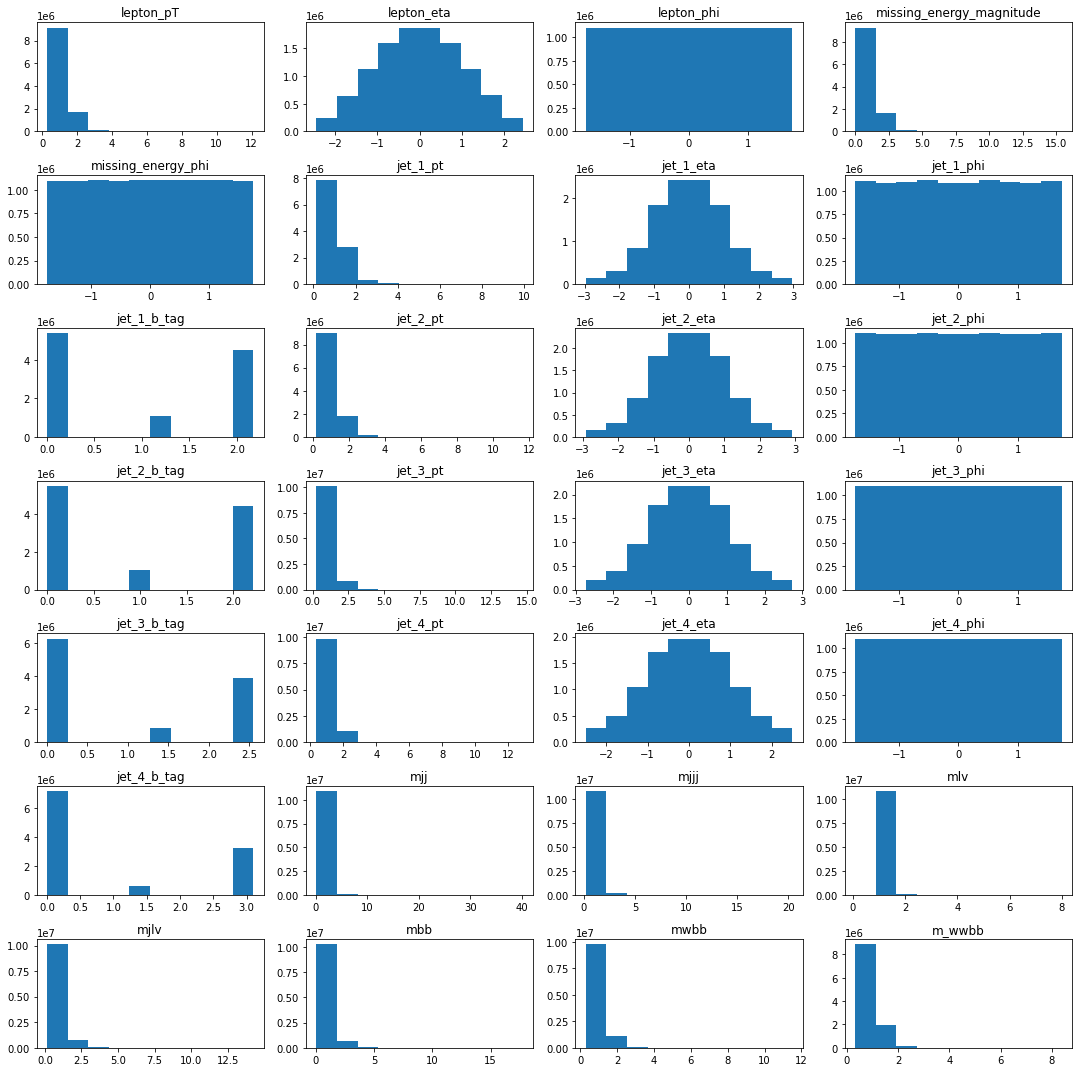

In [13]:
# create subplots with 7 rows and 4 columns and figure size (15,15)
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(15,15))
for i,ax in enumerate(axes.flatten(), start=1):
    # plot histogram of features
    ax.hist(df.iloc[:,i])
    ax.set_title(df.columns[i])
plt.tight_layout()
plt.show()

The correlation matrix shows the ralation between two variables. The value range is from -1 to 1. A value close to 1 means having a high positive correlation and a value close to -1 means having a high negativce correlation. 

In [14]:
# correlation matrix of the dataframe
cor_mat = df.corr()
cor_mat

,class_label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,...,jet_4_eta,jet_4_phi,jet_4_b_tag,mjj,mjjj,mlv,mjlv,mbb,mwbb,m_wwbb
class_label,1.000000,-0.048599,-0.000134,0.000643,-0.099999,-5.385695e-04,0.056908,-0.000003,0.000431,-9.731104e-03,...,-0.000344,0.000432,0.015057,0.012852,0.025545,0.010999,-0.030911,-0.152094,-0.065590,-0.123266
lepton_pT,-0.048599,1.000000,-0.000153,-0.000175,-0.139528,2.316266e-04,0.165798,-0.000135,-0.000335,-6.264733e-03,...,0.000090,-0.000047,0.000139,0.026513,0.017842,0.272327,0.132228,0.007636,0.095841,0.141168
lepton_eta,-0.000134,-0.000153,1.000000,0.000418,-0.000438,1.606021e-04,-0.000396,0.264797,-0.000187,2.749154e-04,...,0.177698,0.000301,-0.000146,0.000306,-0.000133,-0.000272,0.000061,0.000145,-0.000011,0.000072
lepton_phi,0.000643,-0.000175,0.000418,1.000000,-0.000012,-4.451781e-02,-0.000135,0.000793,-0.167880,-1.779953e-04,...,0.000983,-0.065012,-0.000227,0.000358,0.000176,-0.000788,0.000409,-0.000249,0.000207,0.000321
missing_energy_magnitude,-0.099999,-0.139528,-0.000438,-0.000012,1.000000,-2.321502e-04,0.199157,-0.000119,-0.000036,-3.036763e-02,...,-0.000017,-0.000165,0.009673,0.034129,0.032766,0.171896,0.280523,0.025929,0.213948,0.298656
missing_energy_phi,-0.000539,0.000232,0.000161,-0.044518,-0.000232,1.000000e+00,0.000118,-0.000642,-0.154905,9.724859e-07,...,-0.000475,-0.038633,0.000204,-0.000024,0.000355,0.000583,0.000060,0.000662,0.000427,0.000329
jet_1_pt,0.056908,0.165798,-0.000396,-0.000135,0.199157,1.184568e-04,1.000000,-0.000329,-0.000110,-1.563663e-02,...,0.000085,-0.000173,-0.005552,0.186940,0.261443,0.018275,0.278144,0.335090,0.480738,0.450244
jet_1_eta,-0.000003,-0.000135,0.264797,0.000793,-0.000119,-6.424399e-04,-0.000329,1.000000,0.000106,-9.002087e-06,...,0.191889,-0.000280,-0.000070,0.000508,0.000547,0.000585,0.000233,0.000027,0.000528,0.000329
jet_1_phi,0.000431,-0.000335,-0.000187,-0.167880,-0.000036,-1.549053e-01,-0.000110,0.000106,1.000000,5.693281e-05,...,-0.000052,-0.101777,0.000275,-0.000067,-0.000127,-0.000199,-0.000553,-0.000424,-0.000167,-0.000164
jet_1_b_tag,-0.009731,-0.006265,0.000275,-0.000178,-0.030368,9.724859e-07,-0.015637,-0.000009,0.000057,1.000000e+00,...,-0.000170,-0.000275,-0.234233,-0.115780,-0.070605,0.000428,0.132221,0.270451,0.111227,0.003050


Let's check the correlation between the target class label and all other features

In [15]:
cor_mat["class_label"].sort_values(ascending=False)

class_label                 1.000000
jet_1_pt                    0.056908
jet_4_pt                    0.037140
mjjj                        0.025545
jet_2_pt                    0.021891
jet_4_b_tag                 0.015057
jet_3_pt                    0.014865
mjj                         0.012852
mlv                         0.010999
lepton_phi                  0.000643
jet_4_phi                   0.000432
jet_1_phi                   0.000431
jet_1_eta                  -0.000003
lepton_eta                 -0.000134
jet_2_eta                  -0.000183
jet_3_eta                  -0.000208
jet_3_phi                  -0.000268
jet_4_eta                  -0.000344
missing_energy_phi         -0.000539
jet_2_phi                  -0.000734
jet_1_b_tag                -0.009731
jet_3_b_tag                -0.023926
mjlv                       -0.030911
lepton_pT                  -0.048599
jet_2_b_tag                -0.049985
mwbb                       -0.065590
missing_energy_magnitude   -0.099999
m

It can be seen that there is a negative correlation between the class label and features mbb, m_wwbb, missing_energy_magnitude, and mwbb. Let's create scatter plots of these features in relation to the class label. 

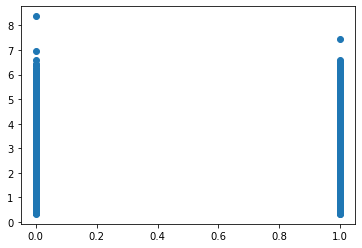

In [79]:
plt.scatter(df['class_label'].to_numpy(), df['m_wwbb'].to_numpy())
plt.show()

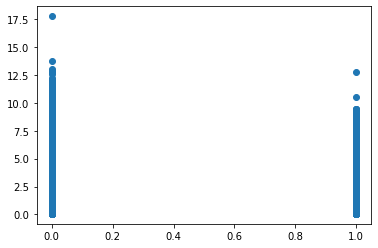

In [80]:
plt.scatter(df['class_label'].to_numpy(), df['mbb'].to_numpy())
plt.show()

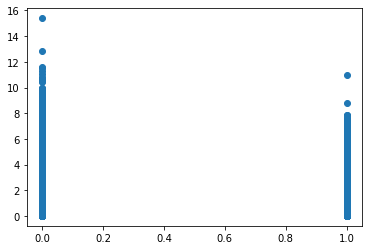

In [81]:
plt.scatter(df['class_label'].to_numpy(), df['missing_energy_magnitude'].to_numpy())
plt.show()

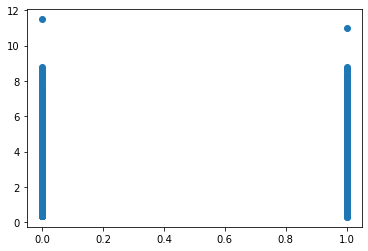

In [82]:
plt.scatter(df['class_label'].to_numpy(), df['mwbb'].to_numpy())
plt.show()

As it can be seen from the plots, the extreme negative outliers is the reason for negative correlation. 

## Data Preprocessing

In [20]:
# the 28 feature column names
feature_names = ['lepton_pT', 'lepton_eta', 'lepton_phi',
'missing_energy_magnitude', 'missing_energy_phi',
'jet_1_pt', 'jet_1_eta', 'jet_1_phi', 'jet_1_b_tag',
'jet_2_pt', 'jet_2_eta', 'jet_2_phi', 'jet_2_b_tag',
'jet_3_pt', 'jet_3_eta', 'jet_3_phi', 'jet_3_b_tag',
'jet_4_pt', 'jet_4_eta', 'jet_4_phi', 'jet_4_b_tag',
'mjj', 'mjjj', 'mlv', 'mjlv', 'mbb', 'mwbb', 'm_wwbb']

In [21]:
# X is the feature set and y is the target variable
X, y = df[feature_names], df['class_label']

### Train Test Split

It is impprtant to split the dataset into train and test set before undergoing any data preprocessing steps. As doing preprocessing on the entire dataset would be a cheating on the test set and letting the model knows about the test set. The Higgs boson dataset is huge, I will be keeping 80% for training and 20% for testing and also, it is a industry standard to split the data in similar fashion. I will be using train_test_split function from cuml model_selection module.

In [22]:
from cuml.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

The shapes of train and test sets given below

In [23]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (8800000, 28)
y_train:  (8800000,)
X_test:  (2199999, 28)
y_test:  (2199999,)


### Scaling of data

Machine Learning algorithms perform better when numerical training features are scaled to a standard range. There are different types of scaling methods. I will be using Standard scaler as it is the industry go to method when dealing with scaling of data. Standardization scales each input variable by subtracting the mean and dividing by the standard deviation.

I will be using standard scaler function from the cuML module

In [24]:
# importing the standard scaler functiomn from cuml experimental
from cuml.experimental.preprocessing import StandardScaler

In [25]:
# initialise standard scaler object
scaler = StandardScaler()
# fit method compute the mean and std to be used for later scaling
scaler.fit(X_train)

StandardScaler()

Both train and test data will be transformed. Because when test data will be used in future for evaluation, it should be in the same format as train data.

In [26]:
# transforms the data by centering and scaling
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
type(X_train_scaled)

cudf.core.dataframe.DataFrame

In [28]:
X_train_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-0.067025,-0.422914,1.593261,-0.619538,-1.190701,-1.074746,-0.518216,0.952915,-0.973204,-0.943955,...,1.033339,-1.710546,-0.714227,-0.184466,0.298994,-0.369979,-0.741695,-0.702538,-0.653327,-0.685326
1,0.181670,-0.056057,1.350658,1.682270,0.787917,-0.188272,0.899607,-0.507518,1.141016,-0.778980,...,2.200456,-1.234144,-0.714227,-0.369711,0.138507,-0.292389,-1.022979,0.153343,-0.106516,-0.231643
2,-0.707868,1.435503,1.264093,0.144005,-0.732461,-0.581361,0.430597,-0.249618,1.141016,0.901751,...,-0.716510,0.629108,-0.714227,-0.082915,-0.128397,0.167533,-0.306258,1.465075,0.682681,0.307153
3,1.511930,0.752957,-1.129512,-1.422910,0.410878,-0.345083,1.022256,0.561106,1.141016,-0.318813,...,1.158151,-1.117250,-0.714227,-0.332168,-0.572749,-0.370823,0.207899,-0.281531,-0.591898,-0.812058
4,0.618830,1.030030,-0.267166,1.098149,-0.023677,-0.511538,1.768944,1.309456,-0.973204,-0.965616,...,0.562194,-1.313545,1.501061,8.130065,6.393324,-0.339278,-0.114124,-0.752379,2.661786,3.732950


### Principal Component Analysis (PCA)

PCA is a dimensionality reduction technique which is used to combine the features and reduce its dimensions. By reducing the number of features EDA or data visualisations can be performed easily. We can import PCA from cuML.

In [29]:
from cuml.decomposition import PCA as PCA_GPU
# I am keeping n_components as 2, so that I can visualize it in a 2D plot. Usually it should be kept a low number.
pca = PCA_GPU(n_components=3)

Now I will fit the data to the PCA model and transform the data into principal components

In [30]:
pca.fit(X_train_scaled)
components = pca.transform(X_train_scaled)
components

,0,1,2
0,-1.566221,0.614328,-0.859165
1,-0.556418,-0.946684,0.681737
2,0.781343,0.329490,1.639014
3,-1.361193,-2.016524,1.406212
4,6.688727,-0.337810,-6.570222
...,...,...,...
8799995,-1.339632,-2.807469,1.686801
8799996,-2.209488,-0.354153,0.899959
8799997,-0.868458,0.785181,-0.963374
8799998,0.327163,1.606878,1.186260


The below cells gives the variance ratio of the components. Let's visualise it with the help of a plot. 

In [31]:
pca.explained_variance_ratio_

0    0.148762
1    0.066608
2    0.064323
dtype: float64

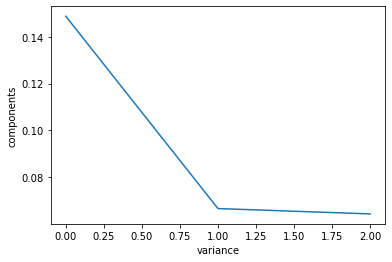

In [32]:
plt.plot(pca.explained_variance_ratio_.values_host)
plt.xlabel('variance')
plt.ylabel('components')
plt.show()

The most variance is shown by the first component. From second component onwards the variance drops significantly.

### Chi squared statistics for top features 

Chi squared test finds the best features from the feature set. The values should be non-negative, so, I will use MinMaxScaler to scale the values between 0 and 1. The chi2 test function is not available in cuML so I will be using it from sklearn.

In [33]:
from sklearn.feature_selection import chi2
from cuml.experimental.preprocessing import MinMaxScaler

Initialising the MinMaxScaler object, fitting the train set to the object and then transforming it.

In [34]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)
X_train_min_max = min_max_scaler.transform(X_train)

Performing chi2 test on the train set to find the top features

In [35]:
chi2_result = chi2(X_train_min_max.values_host, y_train.values_host)

The chi2 test produces chi2 statistics and p-values. Our interest is chi2 statistics, which will give us the scores of each feature

In [36]:
chi2_result[0]

array([8.33889639e+02, 6.85587031e-03, 5.64439981e-01, 2.06230839e+03,
       3.93088048e-01, 7.64245993e+02, 1.76616350e-02, 6.79407179e-01,
       3.80398453e+02, 1.14091059e+02, 6.26938256e-02, 1.51062193e+00,
       1.10563137e+04, 5.68826885e+01, 7.33564379e-02, 2.48067997e-01,
       2.75434381e+03, 3.98476121e+02, 1.39328449e-01, 4.44268923e-01,
       1.23572356e+03, 2.07672030e+01, 6.17545607e+01, 3.82946869e+00,
       1.18544335e+02, 3.42590606e+03, 6.61394181e+02, 2.91915710e+03])

The chi2 scores will be attached with their corresponding features and will be sorted in descending order. The features with highest scores will be at the top.

In [37]:
chi2_stats = zip(feature_names, chi2_result[0])
chi2_sorted = sorted(chi2_stats, key=lambda x: x[1], reverse=True)
chi2_sorted

[('jet_2_b_tag', 11056.313741152433),
 ('mbb', 3425.906061970188),
 ('m_wwbb', 2919.157098672227),
 ('jet_3_b_tag', 2754.3438117485766),
 ('missing_energy_magnitude', 2062.3083876343935),
 ('jet_4_b_tag', 1235.7235643502793),
 ('lepton_pT', 833.8896392709919),
 ('jet_1_pt', 764.2459928176745),
 ('mwbb', 661.3941810997359),
 ('jet_4_pt', 398.47612120272237),
 ('jet_1_b_tag', 380.3984533681722),
 ('mjlv', 118.54433475009236),
 ('jet_2_pt', 114.09105868045233),
 ('mjjj', 61.75456073731941),
 ('jet_3_pt', 56.882688478165065),
 ('mjj', 20.767203042141563),
 ('mlv', 3.829468690227488),
 ('jet_2_phi', 1.510621932787965),
 ('jet_1_phi', 0.6794071788191396),
 ('lepton_phi', 0.5644399808197249),
 ('jet_4_phi', 0.4442689226610921),
 ('missing_energy_phi', 0.39308804786399676),
 ('jet_3_phi', 0.24806799733500529),
 ('jet_4_eta', 0.13932844933353628),
 ('jet_3_eta', 0.07335643785519627),
 ('jet_2_eta', 0.06269382561306241),
 ('jet_1_eta', 0.0176616349985038),
 ('lepton_eta', 0.006855870310376865)]

It can be seen that the feature jet_2_b_tag is the top feature with highest score followed by mbb, m_wwbb and so on. Lets create a plot to visualise it.

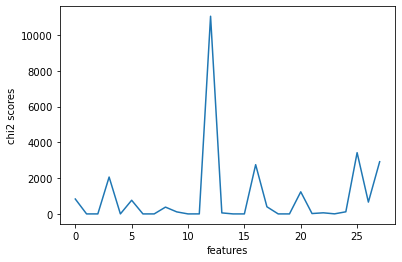

In [38]:
plt.plot(chi2_result[0])
plt.xlabel('features')
plt.ylabel('chi2 scores')
plt.show()